# Deep Learning Heart Disease Prediction - Preprocessing: Mel-Spectrum

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import librosa
import librosa.display
from scipy.signal import spectrogram
import soundfile as sf

In [ ]:
!gdown -O RECORDS https://physionet.org/files/circor-heart-sound/1.0.3/RECORDS?download
!gdown -O training_data.csv https://physionet.org/files/circor-heart-sound/1.0.3/training_data.csv?download
!mkdir training_data
records = [id[14:] for id in open("./RECORDS", "r").read().split("\n") if id != ""]
training_data = pd.read_csv("training_data.csv", index_col="Patient ID")
patients = [int(id) for id in training_data.index.to_list()]

Downloading...
From: https://physionet.org/files/circor-heart-sound/1.0.3/RECORDS?download
To: /content/RECORDS
100% 72.8k/72.8k [00:00<00:00, 362kB/s]
Downloading...
From: https://physionet.org/files/circor-heart-sound/1.0.3/training_data.csv?download
To: /content/training_data.csv
100% 117k/117k [00:00<00:00, 304kB/s]
mkdir: invalid option -- 'f'
Try 'mkdir --help' for more information.


In [ ]:
ftypes = ["hea", "tsv", "wav"]
train_data_location = "./training_data"

def download_record(record_id: str):
  for ftype in ftypes:
    if not os.path.exists(f"{train_data_location}/{record_id}.{ftype}"):
      os.system(f"gdown -O {train_data_location}/{record_id}.{ftype} https://physionet.org/files/circor-heart-sound/1.0.3/training_data/{record_id}.{ftype}?download")

def download_patient(patient_id: str or int):
  patient_id = int(patient_id)
  associated_record = [id for id in records if int(id.split("_")[0]) == patient_id]
  if not os.path.exists(f"{train_data_location}/{patient_id}.txt"):
    os.system(f"gdown -O {train_data_location}/{patient_id}.txt https://physionet.org/files/circor-heart-sound/1.0.3/training_data/{patient_id}.txt?download")
  for id in associated_record:
    download_record(id)


In [ ]:
def get_melspec(patient_id: int, display: bool = False):
    file_name = f"{train_data_location}/{patient_id}_MV.wav"
    y, sr = librosa.load(file_name)
    ms = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    return ms, sr

def get_power_accumulation(y: np.ndarray, window_size=20):
    return np.apply_along_axis(lambda row: np.convolve(row, np.ones(window_size), mode='same'), axis=1, arr=y)

def draw_dbspec(y: np.ndarray, sr: float):
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(y, ref=np.max)
    img = librosa.display.specshow(
        S_dB, x_axis='time',
        y_axis='mel',
        sr=sr,
        fmax=8000,
        ax=ax
    )
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=f'Mel-frequency spectrogram')

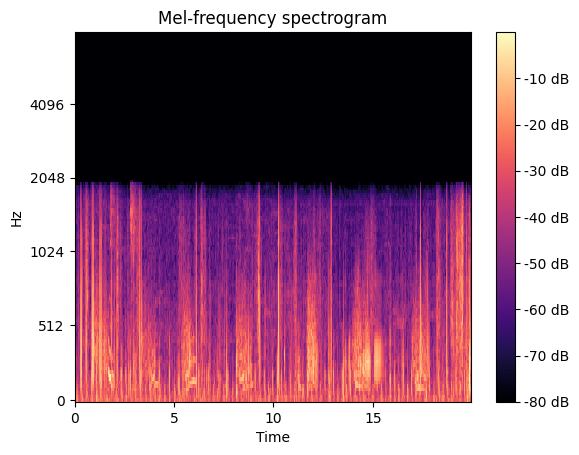

In [ ]:
demo_patient = patients[2]
download_patient(demo_patient)
ms, sr = get_melspec(demo_patient)
draw_dbspec(ms, sr)

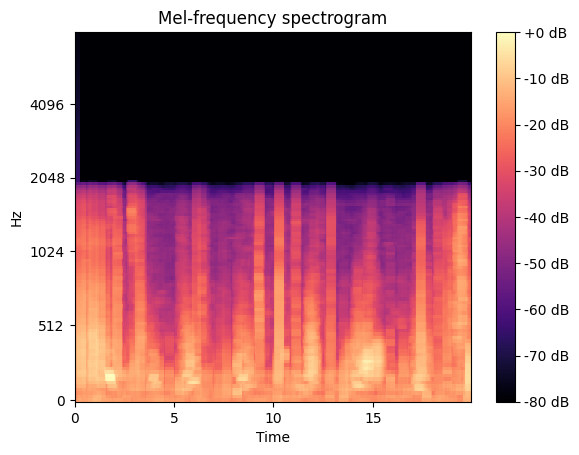

In [ ]:
draw_dbspec(get_power_accumulation(ms), sr)

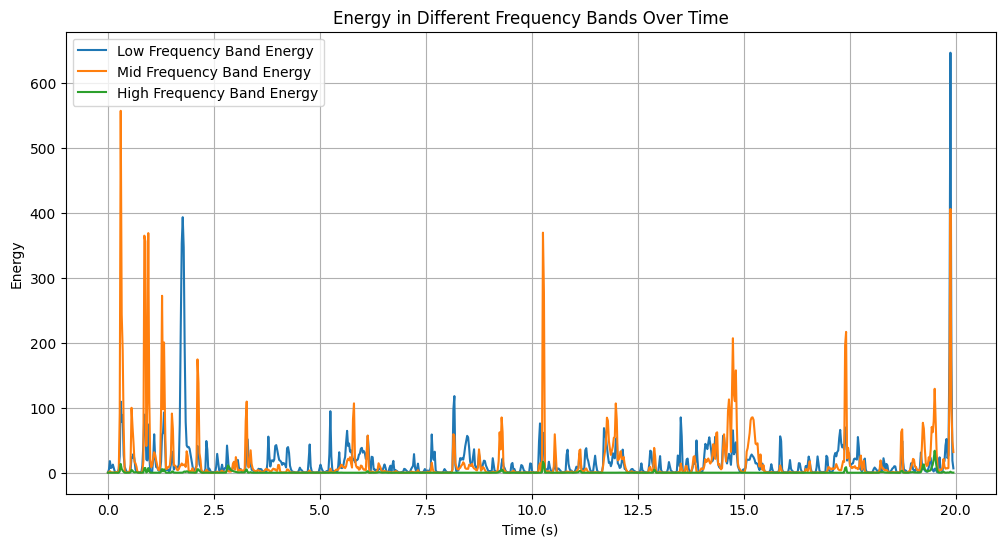

In [ ]:
S = ms
n_fft = 2048
hop_length = 512

# Define frequency bands
low_freq_band = (0, 100)  # Define the frequency range in Hz
mid_freq_band = (100, 500)
high_freq_band = (500, 1000)

# Function to extract energy from a frequency band
def extract_band_energy(S, frequency_range):
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    lower_idx = np.where(freqs >= frequency_range[0])[0][0]
    upper_idx = np.where(freqs <= frequency_range[1])[0][-1]
    band_energy = np.sum(S[lower_idx:upper_idx, :], axis=0)
    return band_energy

# Extract energy from different frequency bands
low_freq_energy = extract_band_energy(S, low_freq_band)
mid_freq_energy = extract_band_energy(S, mid_freq_band)
high_freq_energy = extract_band_energy(S, high_freq_band)

time_axis = np.arange(0, len(low_freq_energy)) * hop_length / sr

# Plot energy in different frequency bands
plt.figure(figsize=(12, 6))
plt.plot(time_axis, low_freq_energy, label='Low Frequency Band Energy')
plt.plot(time_axis, mid_freq_energy, label='Mid Frequency Band Energy')
plt.plot(time_axis, high_freq_energy, label='High Frequency Band Energy')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.legend()
plt.title('Energy in Different Frequency Bands Over Time')
plt.grid()
plt.show()

